# Assignment 02 - The simplest model order selection

The assignment extends Assignment 01 by adding two ingredients:
1. considering not only Least Squares but also Maximum Likelihood
2. adding the possibility of choosing different model orders

# task 2.1

Consider the same situation of tasks 1.1 and 1.2 in assignment 1, but with the additional possibility of ‘faulty measurements’ in the following sense: with a probability $\gamma$ the sensor returns something meaningless, i.e., with probability $\gamma$ $e_t$ is so that $y_t = 100$. With probability $1 - \gamma$, instead, the sensor works fine and thus the same probabilistic model for generating $e_t$ applies. Note: the outlier events are i.i.d., i.e., the fact that one has an outlier at time $t$ does not modify the probability of having an outlier also at time $t+1$.

In [227]:
# importing the right packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize

In [228]:
# define the function that creates an arbitrary polynomial
# that we will use also to create the scalar quadratic
# 'true model'
#
# note that this function uses both 'lambda functions' and
# the 'enumerate' function -- two features of python
def arbitrary_poly(theta):
    noiseless_y = lambda x: sum([p*(x**i) for i, p in enumerate(theta)])
    return noiseless_y

In [229]:
# Non-random generation between code executions.
# Comment out if you want to repeat the same experiment over and over again
# np.random.seed(123)

In [230]:
# define the function for the mixture distribution
def noise(gamma, alpha, beta, sigma, N):
    
    # generate the noises as before
    if np.random.uniform() < alpha:
        noise = np.random.normal(0, sigma, N)
    else:
        noise = np.random.laplace(0, beta, N)

    # use \infty as a placeholder for the iid events 'faulty measurement'
    for i in range(N):
        if np.random.uniform() < gamma:
            noise[i] = np.inf
    
    return noise

# task 2.2

With respect to assignment 1, though, modify the $u_t$'s so to be 201 uniformly spaced values in $[-3, 3]$, and set $\alpha = 0$ so that we have Laplacian noises (more precisely, with scale $\beta = 1$). Keep the "true model" quadratic.

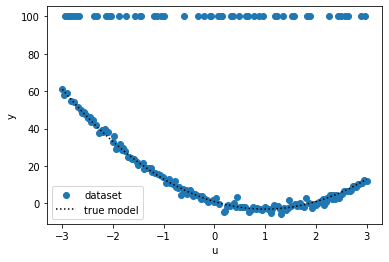

In [231]:
# for readability
min_u = -3
max_u = 3
N     = 201 # number of samples

# create the u_t's
u = np.linspace(min_u, max_u, N)

# set the required parameters
theta_true = [1, -8, 4]
gamma      = 0.2
beta       = 1
sigma      = 1
alpha      = 0

# create the noisy dataset
noiseless_y = arbitrary_poly(theta_true) # use the lambda function
y = noiseless_y( u ) + noise( gamma, alpha, beta, sigma, len(u) )

# remember to account for the 'faulty measurements'!
y[np.isinf(y)] = 100

# plot the dataset, for debugging purposes
x = np.linspace(start = min_u, stop = max_u, num = 100)
plt.figure()
plt.scatter(u, y,                  label = 'dataset')
plt.plot(x, noiseless_y(x),  'k:', label = 'true model')
plt.xlabel('u')
plt.ylabel('y')
plt.legend();

# task 2.3

Code both a Least Squares and a Maximum Likelihood estimator whose underlying assumption on the measurement noise is Laplacian.

Add also the possibility of testing generic model structures (i.e., affine, quadratic, cubic, and so-on models).

In [232]:
# define the function solving the LS problem asked in the assignment
def LS_solver( u, y, model_order ):

    # create the features matrix
    U = u[:, np.newaxis] ** np.arange( model_order )

    # compute the LS estimate by directly solving the normal equations
    theta_hat = np.linalg.solve(U.T @ U, U.T @ y)

    return theta_hat

In [233]:
def laplace_log_likelihood(theta, u, y):
    
    # probability distribution p, "know" beta = 1 but leave for expm.
    beta = 1
    
    U = u[:, np.newaxis] ** np.arange(len(theta))
    mu = theta@U.T
    negative_log_likelihood = -sum(np.log((1.0/(2*beta)*np.exp(-np.abs(y - mu)/beta))))
    
    return negative_log_likelihood

In [234]:
# define the function solving the ML problem asked in the assignment
def ML_solver( u, y, model_order ):

    # compute the ML estimate by directly minimizing the log likelihood
    opt_res = optimize.minimize(
                fun     = laplace_log_likelihood,
                x0      = np.zeros( model_order ),
                args    = (u, y),
                options = {'disp': False} )

    # save the result in a more readable format
    theta_hat = opt_res.x
    
    # debug
    #print('estimated parameters ML = ', theta_hat)
    
    return theta_hat

# task 2.4

Split the dataset so that the first half is the training set, the second 25% is the test set, and the last 25% is the validation set.

Code a function that returns the "performance index" of a generic estimate $\widehat{\theta}$ on a generic dataset $y$. The index shall be equal to the sum of the absolute deviations between the actually measured $y$'s and the predicted ones $\widehat{y}_t$, i.e.,

$$
    \widehat{y}_t
    =
    \left[ \widehat{\theta}_0, \widehat{\theta}_1, \widehat{\theta}_2, \ldots \right]
    \left[ 1, u_t, u_t^2, \ldots \right]^T .
$$

In [235]:
# split the dataset
training_u   = u[:100]
training_y   = y[:100]
#
testing_u    = u[101:150]
testing_y    = y[101:150]
#
validating_u = u[151:]
validating_y = y[151:]

In [236]:
# define the performance index
def performance_index( measured_y, estimated_y ):
    return sum([abs(y - y_hat) for y, y_hat in zip(measured_y, estimated_y)])

PI = Performance Index - lower is better
PI LS on training set:  2675.0603179515506
PI ML on training set:  1843.875019195568
PI LS on test set:      2176.089594450781
PI ML on test set:      1463.8873608056847


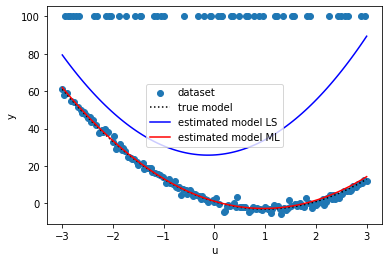

In [237]:
# DEBUG
# check that everything works

# set a model order, just to check that things work
guessed_model_order = 3

# solve the LS and ML problems
theta_hat_LS = LS_solver( training_u, training_y, guessed_model_order )
theta_hat_ML = ML_solver( training_u, training_y, guessed_model_order )

# compute the estimated models
modeled_y_LS = arbitrary_poly(theta_hat_LS) # use the lambda function
modeled_y_ML = arbitrary_poly(theta_hat_ML) # use the lambda function

# plot the true model against the measurements and the estimated model
x = np.linspace(start = min_u, stop = max_u, num = 100)
plt.figure()
plt.scatter(u, y,                  label = 'dataset')
plt.plot(x, noiseless_y(x),  'k:', label = 'true model')
plt.plot(x, modeled_y_LS(x), 'b',  label = 'estimated model LS')
plt.plot(x, modeled_y_ML(x), 'r',  label = 'estimated model ML')
plt.xlabel('u')
plt.ylabel('y')
plt.legend();

# print the performance indexes
print("PI = Performance Index - lower is better")
print( 'PI LS on training set: ', performance_index( training_y, modeled_y_LS(training_u) ) )
print( 'PI ML on training set: ', performance_index( training_y, modeled_y_ML(training_u) ) )
print( 'PI LS on test set:     ', performance_index( testing_y, modeled_y_LS(testing_u) ) )
print( 'PI ML on test set:     ', performance_index( testing_y, modeled_y_ML(testing_u) ) )

# task 2.5

Comment the plot above. Why are these behaviours happening?

The least-squares estimator is purely geometric, and does not rely on any assumptions about the data set and its distribution. The estimator thus struggles with the outliers, since they are weighed equally when minimizing the distance between the dataset and the thetas in the manifold of the assumed model.

The maximum likelihood estimator however, does utilize assumptions about the distribution of the data. Here we assume laplacian noise (which is true), although we do not directly account for the outliers per say. However, the effect that the outliers have on the resulting estimate is greatly reduced since we "believe" less in the outliers as compared to the LS approach, and thus they affect the resulting thetas less.

# task 2.6

Create a table summarizing how the performance indexes vary as a function of the model order of the estimator on the training and test sets.

In [238]:
# choose the max model order
max_model_order = 5

ls_pis = []
ml_pis = []
# cycle on the various model orders
for current_order in range(1, max_model_order+1):

    # train on the training set
    theta_hat_LS = LS_solver( training_u, training_y, current_order )
    theta_hat_ML = ML_solver( training_u, training_y, current_order )

    # create the estimated models
    modeled_y_LS = arbitrary_poly(theta_hat_LS) # use the lambda function
    modeled_y_ML = arbitrary_poly(theta_hat_ML) # use the lambda function

    # predict the test set
    predicted_testing_y_LS = modeled_y_LS(testing_u)
    predicted_testing_y_ML = modeled_y_ML(testing_u)

    # compute the performance indexes on the predictive capabilities on the test set
    PI_LS = performance_index(predicted_testing_y_LS, testing_y)
    PI_ML = performance_index(predicted_testing_y_ML, testing_y)
    
    ls_pis.append(PI_LS)
    ml_pis.append(PI_ML)
    
for o, pi in enumerate(ls_pis):
    # print debug info
    print(f"PI for LS w. order {o+1}: {pi}")
    
print("\n\n") 

for o, pi in enumerate(ml_pis):
    print(f"PI for ML w. order {o+1}: {pi}")


PI for LS w. order 1: 2380.247041064765
PI for LS w. order 2: 1578.3769150437079
PI for LS w. order 3: 2176.089594450781
PI for LS w. order 4: 3872.1888101730483
PI for LS w. order 5: 18215.347086380818



PI for ML w. order 1: 2127.708659420074
PI for ML w. order 2: 2311.101230387413
PI for ML w. order 3: 1463.8873608056847
PI for ML w. order 4: 1486.186141388482
PI for ML w. order 5: 1604.6847797617463


# task 2.7

Rerun the code for different values of $\gamma$, and check how the performance capabilities of the LS and ML estimators on the training set vary. Explicitly say:

1. Which estimator seems more robust, in average? And why?
2. Which estimator is so that its performance degrade least gracefully with increasing $\gamma$? And why?
3. Which model order would you choose, given the simulations that you have run? And why?

1: Thinking of the term "robustness" as "less prone to error given changes in the model and/or dataset" then I would consider the ML estimator as more robust than the LS estimator. This is reasonable given that we, as the programmer in the driver seat, have added laplacian noise, and are correctly assuming that the model is corrupted by the laplacian noise. Because of the same arguments as above, our "belief" of the laplacian distribution leads to the outliers affecting the estimator less.

2: I would argue that the ML estimator degrades least gracefully, since it suddenly "jumps" to following the outliers at a certain point. The LS estimator performs worse over most gammas, although the performance doesn't jump around. This happens since, at a certain point, the outliers "win" over our assumption that the data is laplacian distributed - "winning" as in, the outliers are more prevalent in the dataset than the modelled data, such that the argmax of the distribution of the data describes the outliers themselves, and not the model generating the actual data.

3: I would choose order 3 or 4 since the performance for the ML estimator across most gammas is the best for these orders. I prioritize the ML estimator performing well over the LS estimator due to the ML estimator being more robut/a better fit for this problem (as it is defined at least).